In [1]:
# In this part the libraries are imported
# Spark structure is setted.
import os
import time
import datetime
import hashlib
import json
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion, OneHotEncoderEstimator, CountVectorizer, Binarizer, StringIndexer, QuantileDiscretizer
import pyspark.sql.types as T
import pyspark.sql.functions as F

In [2]:
spark = SparkSession \
    .builder \
    .config('spark.app.name', 'Denek') \
    .config('spark.jars', '/home/appuser/ojdbc6.jar') \
    .config('spark.master', 'local[*]') \
    .config('spark.driver.memory', '100g') \
    .config('spark.driver.maxResultSize', '100g') \
    .config('spark.executer.memory', '1g') \
    .config('spark.executer.cores', '1000') \
    .config('spark.cores.max', '1000') \
    .config('spark.python.worker.memory', '1g') \
    .config('spark.sql.shuffle.partitions', '1000') \
    .config('spark.sql.broadcastTimeout', '36000') \
    .getOrCreate()
sc = spark.sparkContext

In [20]:
#df = spark.read.format("csv").option("header", "true").load("datasetAll.csv")
df = spark.read.csv('datasetAll.csv', header='true', inferSchema='true')

In [21]:
df.printSchema()

root
 |-- MIM-HourPerBrowsing: double (nullable = true)
 |-- MIM-NumEditEvent: integer (nullable = true)
 |-- MIM-NumRareBrws: double (nullable = true)
 |-- MIM-TimeSpent: double (nullable = true)
 |-- MIM-HourPerEditing: double (nullable = true)
 |-- MIM-NumEditingDevelopers: integer (nullable = true)
 |-- MIM-NumRareEdit: double (nullable = true)
 |-- MIM-TimeSpentAfterEdit: double (nullable = true)
 |-- MIM-MaxTimeIntervalBrwsBrws: double (nullable = true)
 |-- MIM-NumInterruptions: double (nullable = true)
 |-- MIM-NumRepeatedEdit: double (nullable = true)
 |-- MIM-TimeSpentBeforeEdit: double (nullable = true)
 |-- MIM-MaxTimeIntervalBrwsEdit: double (nullable = true)
 |-- MIM-NumParallelBrws: double (nullable = true)
 |-- MIM-NumSelectionEvent: integer (nullable = true)
 |-- MIM-MaxTimeIntervalEditEdit: double (nullable = true)
 |-- MIM-NumParallelEdit: double (nullable = true)
 |-- MIM-TimeSinceLastTask: double (nullable = true)
 |-- MIM-NumMultiTasks: double (nullable = true)
 |

In [22]:
df.select("*").toPandas().head().transpose()

,0,1,2,3,4
MIM-HourPerBrowsing,28.821882,28.459457,395.150632,0.008681,42.999096
MIM-NumEditEvent,97.000000,207.000000,503.000000,3.000000,488.000000
MIM-NumRareBrws,0.006329,0.043478,0.000000,0.000000,0.032051
MIM-TimeSpent,340.090761,372.069971,600.970585,16.967153,201.214293
MIM-HourPerEditing,30.598791,4.285104,384.589949,0.014167,17.916694
...,...,...,...,...,...
HM-AvgOfCodeChurn,-2.139535,-2.777778,0.700000,0.000000,1.875000
HM-NumOfAuthors,3.000000,2.000000,3.000000,1.000000,4.000000
HM-Age,4.000000,104.000000,46.000000,387.000000,75.000000
HM-WeightedAge,51.693779,46.436462,75.728645,166.000000,49.953075


## Summary Statistics

In [23]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
df.describe(numeric_features).toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
MIM-HourPerBrowsing,3077,70.65785016249538,243.89191382130255,2.78E-4,7562.35375
MIM-NumEditEvent,3077,55.145271368215795,262.997825708884,0,9674
MIM-NumRareBrws,3077,0.32616039616509535,2.1964266409497593,0.0,40.0
MIM-TimeSpent,3077,286.3162544033142,340.40288321507506,0.0,4565.021389
...,...,...,...,...,...
HM-AvgOfCodeChurn,3077,2.9261295622359436,8.288800842970602,-43.153846,110.625
HM-NumOfAuthors,3077,2.571010724731882,1.6497363698291188,0,12
HM-Age,3077,106.85505362365942,83.14677387502485,0,424
HM-WeightedAge,3077,76.27783309912242,52.01435025014985,0.0,193.0


## Correlations and Data Preparation

In [17]:
sampled_data = df.select(numeric_features).sample(False, 0.05)
print("The sampled dataset contains {} samples.".format(sampled_data.count()))

The sampled dataset contains 146 samples.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

g = sns.pairplot(sampled_data.toPandas(), diag_kind="kde")
g.fig.subplots_adjust(top=0.93, wspace=0.2)
g.fig.suptitle('Bug Attributes Pairwise Plots', fontsize=18, fontweight='bold')

## Using the Spark MLlib Package

In [26]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree

def labelData(data):
    # label: row[end], features: row[0:end-1]
    return data.rdd.map(lambda row: LabeledPoint(row[-1], row[:-1]))

training_data, testing_data = labelData(df).randomSplit([0.8, 0.2])

print("The two first rows of the training data RDD:")
print(training_data.take(2))
print("============================")

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={},
                                     impurity='gini', maxBins=32)
print(model.toDebugString())

The two first rows of the training data RDD:
[LabeledPoint(1.0, [28.459457,207.0,0.043478,372.069971,4.285104,4.0,0.0,104.128819,2810.553889,11.322981,6.099379,80.158845,2810.563056,18.857143,160.0,2810.565833,9.018634,811.101111,8.099379,0.79234,10.745342,732.841892,416.400144,327.445168,2.0,6.0,68.0,10.0,0.35,5.0,2.0,1.0,4.0,11.0,32.0,20.0,22.0,43.0,2.0,14.0,5.0,15.0,2.0,21.0,9.0,8.0,8.0,6.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,1.0,50.0,18.0,181.0,231.0,51.0,132.0,10.0,12.0,0.0,24.0,-50.0,-2.777778,2.0,104.0,46.436462]), LabeledPoint(1.0, [395.150632,503.0,0.0,600.970585,384.589949,1.0,0.0,473.460556,5084.036667,11.315789,3.631579,0.134872,5084.204444,17.947368,565.0,5084.204722,6.789474,5885.3525,3.421053,0.736879,8.684211,247.238067,155.983594,137.132662,2.0,21.0,1309.0,96.0,0.62,21.0,2.0,1.0,66.0,387.0,612.0,224.0,426.0,793.0,3.0,423.0,21.0,488.0,2.0,225.0,207.0,192.0,189.0,104.0,0.875,0.0,0.875,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,8.0,0.0,0.0,0.0,1.0

In [27]:
print("Feature 1 is the {}.".format(df.columns[1]))

Feature 1 is the MIM-NumEditEvent.


In [29]:
def printAllMetrics(predictionsDF):
  predictionsDF.groupBy('label', 'predictedLabel').count().show()
  print("=*=*=*=*=*=*=*=*=*=*=*=*=*=")
  TP = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 1.0").count()
  FN = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 0.0").count()
  TN = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 0.0").count()
  FP = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 1.0").count()

  precision_p   = TP/(TP+FP)
  precision_n   = TN/(TN+FN)
  recall_p      = TP/(TP+FN)
  recall_n      = TN/(TN+FP)
  f1_p          = 2*precision_p*recall_p/(precision_p+recall_p)
  f1_n          = 2*precision_n*recall_n/(precision_n+recall_n)
  avg_precision = (precision_p*(TP+FN)+precision_n*(TN+FP))/(TP+FN+TN+FP)
  avg_recall    = (recall_p*(TP+FN)+recall_n*(TN+FP))/(TP+FN+TN+FP)
  avg_f1        = (f1_p*(TP+FN)+f1_n*(TN+FP))/(TP+FN+TN+FP)
  accuracy      = (TN+TP)/(TP+FN+TN+FP)
 
  print('Precision of True    ', precision_p)
  print('Precision of False   ', precision_n)
  print('** Avg Precision     ', avg_precision)
  print('Recall of True       ', recall_p)
  print('Recall of False      ', recall_n)
  print('** Avg Recall        ', avg_recall)
  print('F1 of True           ', f1_p)
  print('F1 of False          ', f1_n)
  print('** Avg F1            ', avg_f1)
  print('** Accuracy          ', accuracy)

In [30]:
from pyspark.mllib.evaluation import MulticlassMetrics

def getPredictionsLabels(model, test_data):
  predictions = model.predict(test_data.map(lambda r: r.features))
  return predictions.zip(test_data.map(lambda r: r.label))

def printMetrics(predictions_and_labels):
  metrics = MulticlassMetrics(predictions_and_labels)
  print('Confusion Matrix\n', metrics.confusionMatrix().toArray())
  print('Precision of True    ', metrics.precision(1))
  print('Precision of False   ', metrics.precision(0))
  print('Weighted Precision   ', metrics.weightedPrecision)
  print('Recall of True       ', metrics.recall(1))
  print('Recall of False      ', metrics.recall(0))
  print('Weighted Recall      ', metrics.weightedRecall) 
  print('FMeasure of True     ', metrics.fMeasure(1.0, 1.0))
  print('FMeasure of False    ', metrics.fMeasure(0.0, 1.0))
  print('Weighted fMeasure    ', metrics.weightedFMeasure())
  print('Accuracy             ', metrics.accuracy)

In [31]:
predictions_and_labels = getPredictionsLabels(model, testing_data).cache()
printMetrics(predictions_and_labels)

Confusion Matrix
 [[483.  18.]
 [ 72.  32.]]
Precision of True     0.64
Precision of False    0.8702702702702703
Weighted Precision    0.8306866205048024
Recall of True        0.3076923076923077
Recall of False       0.9640718562874252
Weighted Recall       0.8512396694214875
FMeasure of True      0.4155844155844156
FMeasure of False     0.9147727272727274
Weighted fMeasure     0.8289618439411829
Accuracy              0.8512396694214877


In [32]:
predictionsdf = predictions_and_labels.toDF(["predictedLabel","label"])
printAllMetrics(predictionsdf)

+-----+--------------+-----+
|label|predictedLabel|count|
+-----+--------------+-----+
|  1.0|           1.0|   32|
|  0.0|           1.0|   18|
|  1.0|           0.0|   72|
|  0.0|           0.0|  483|
+-----+--------------+-----+

=*=*=*=*=*=*=*=*=*=*=*=*=*=
Precision of True     0.64
Precision of False    0.8702702702702703
** Avg Precision      0.8306866205048022
Recall of True        0.3076923076923077
Recall of False       0.9640718562874252
** Avg Recall         0.8512396694214877
F1 of True            0.4155844155844156
F1 of False           0.9147727272727274
** Avg F1             0.8289618439411829
** Accuracy           0.8512396694214877


In [33]:
df.groupby('Buggy').count().show()

+-----+-----+
|Buggy|count|
+-----+-----+
|    1|  515|
|    0| 2562|
+-----+-----+



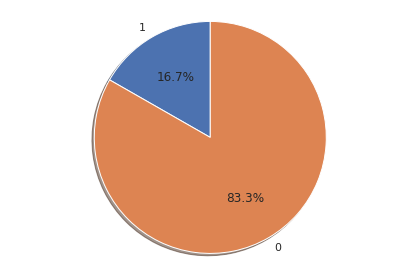

In [34]:
import matplotlib.pyplot as plt
# Pie chart
labels = df.groupby('Buggy').count().toPandas().Buggy.tolist()
sizes = df.groupby('Buggy').count().toPandas()["count"].tolist()
explode = (0, 0)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.show()

## Stratified Sampling

In [35]:
stratified_data = df.sampleBy('Buggy', fractions={0: df.select("Buggy").where('Buggy == 1').count()/ df.select("Buggy").where('Buggy == 0').count(), 1: 1.0}, seed = 5323)
stratified_data.groupby('Buggy').count().show()

+-----+-----+
|Buggy|count|
+-----+-----+
|    1|  515|
|    0|  518|
+-----+-----+



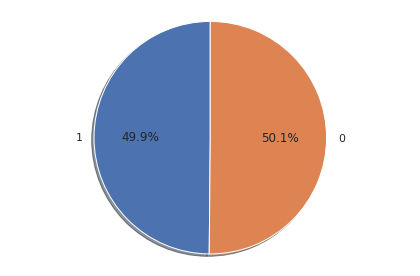

In [36]:
labels = stratified_data.groupby('Buggy').count().toPandas().Buggy.tolist()
sizes = stratified_data.groupby('Buggy').count().toPandas()["count"].tolist()
explode = (0, 0)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [37]:
training_data, testing_data = labelData(stratified_data).randomSplit([0.8, 0.2])
model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2, categoricalFeaturesInfo={}, impurity='gini', maxBins=32)

predictions_and_labels = getPredictionsLabels(model, testing_data).cache()
printMetrics(predictions_and_labels)
print("========================================")
predictionsdf = predictions_and_labels.toDF(["predictedLabel","label"])
printAllMetrics(predictionsdf)

Confusion Matrix
 [[44. 57.]
 [33. 75.]]
Precision of True     0.5681818181818182
Precision of False    0.5714285714285714
Weighted Precision    0.56975082333934
Recall of True        0.6944444444444444
Recall of False       0.43564356435643564
Weighted Recall       0.569377990430622
FMeasure of True      0.625
FMeasure of False     0.49438202247191015
Weighted fMeasure     0.5618783936347509
Accuracy              0.569377990430622
+-----+--------------+-----+
|label|predictedLabel|count|
+-----+--------------+-----+
|  1.0|           1.0|   75|
|  0.0|           1.0|   57|
|  1.0|           0.0|   33|
|  0.0|           0.0|   44|
+-----+--------------+-----+

=*=*=*=*=*=*=*=*=*=*=*=*=*=
Precision of True     0.5681818181818182
Precision of False    0.5714285714285714
** Avg Precision      0.56975082333934
Recall of True        0.6944444444444444
Recall of False       0.43564356435643564
** Avg Recall         0.569377990430622
F1 of True            0.625
F1 of False           0.4943820

## Using the Spark ML Package

In [40]:
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml import Pipeline

def get_dummy(df, numericCols, labelCol):
  # Combining a given list of columns into a single vector column features
  assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
  # Index labels, adding metadata to the label column
  indexer = StringIndexer(inputCol=labelCol, outputCol='indexedLabel')
  # Automatically identify categorical features and index them
  featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=2)
  pipeline = Pipeline(stages = [assembler] + [indexer] + [featureIndexer])
  model = pipeline.fit(df)
  data = model.transform(df)
  data = data.withColumn('label', F.col(labelCol))
  return data.select('features', 'label', 'indexedFeatures', 'indexedLabel')

In [43]:
numericCols = stratified_data.columns
numericCols.remove("Buggy")

vectorized_data = get_dummy(df, numericCols, "Buggy")
vectorized_stratified_data = get_dummy(stratified_data, numericCols, "Buggy")

In [44]:
vectorized_stratified_data.show(2, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## K-fold cross validation

In [48]:
def cvComparing(vectorized_train_data, vectorized_test_data, classifiers, paramGrid, numFolds, roundLevel, seed):
  names = []
  underROC_train = []
  # underROC_test = []
  f1_train = []
  # f1_test = []
  wp_train = []
  # wp_test = []
  wr_train = []
  # wr_test = []
  acc_train = []
  # acc_test = []

  evaluatorB = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="indexedLabel")
  evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1") 
  evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision") 
  evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall") 
  evaluatoracc = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy") 

  for name, clf in classifiers:
    cv = CrossValidator(estimator=clf, estimatorParamMaps=paramGrid, evaluator=evaluatorf1, numFolds=numFolds, seed=seed, collectSubModels=True)
    cvModel = cv.fit(vectorized_train_data)  
    predict_train = cvModel.transform(vectorized_train_data)
    # predict_test = cvModel.transform(vectorized_test_data)
    underROC_train.append(evaluatorB.evaluate(predict_train))
    # underROC_test.append(evaluatorB.evaluate(predict_test))
    f1_train.append(evaluatoracc.evaluate(predict_train))
    # f1_test.append(evaluatoracc.evaluate(predict_test))
    wp_train.append(evaluatorwp.evaluate(predict_train))
    # wp_test.append(evaluatorwp.evaluate(predict_test))
    wr_train.append(evaluatorwr.evaluate(predict_train))
    # wr_test.append(evaluatorwr.evaluate(predict_test))
    acc_train.append(evaluatoracc.evaluate(predict_train))
    # acc_test.append(evaluatoracc.evaluate(predict_test))
    names.append(name)

  #cvResults = spark.createDataFrame(zip(names, underROC_train, underROC_test, acc_train, acc_test, f1_train, f1_test, wp_train, wp_test, wr_train, wr_test), schema=['Classifier name', 'underROC_train', 'underROC_test', 'Accuracy_train', 'Accuracy_test', 'f1_train', 'f1_test', 'wPrecision_train', 'wPrecision_test', 'wRecall_train', 'wRecall_test'])
  cvResults = spark.createDataFrame(zip(names, underROC_train, acc_train, f1_train, wp_train, wr_train), schema=['Classifier name', 'underROC_train','Accuracy_train', 'f1_train','wPrecision_train', 'wRecall_train'])
  for t in cvResults.dtypes:
    if t[1] == 'double':
      cvResults = cvResults.withColumn(t[0], F.round(cvResults[t[0]], roundLevel))
  
  return cvResults

In [49]:
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder().build()
classifiers = []
##############################################
classifiers.append(('LR', LogisticRegression(labelCol='indexedLabel', featuresCol='indexedFeatures')))
#classifiers.append(('NB', NaiveBayes(labelCol='indexedLabel', featuresCol='indexedFeatures'))) # Naive Bayes requires nonnegative feature values but found
classifiers.append(('SVC', LinearSVC(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('DT', DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('RF', RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('GBT', GBTClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
##############################################

cvResults_data = cvComparing(vectorized_train_data = vectorized_data, vectorized_test_data = '', classifiers = classifiers, paramGrid = paramGrid, numFolds = 5, roundLevel = 3, seed = 123)
cvResults_stratified_data = cvComparing(vectorized_train_data = vectorized_stratified_data, vectorized_test_data = '', classifiers = classifiers, paramGrid = paramGrid, numFolds = 5, roundLevel = 3, seed = 123)


                      0      1      2      3      4
Classifier name      LR    SVC     DT     RF    GBT
underROC_train    0.565  0.508  0.734  0.689  0.843
Accuracy_train    0.837  0.835  0.887  0.882  0.935
f1_train          0.837  0.835  0.887  0.882  0.935
wPrecision_train    0.8  0.844  0.878  0.874  0.933
wRecall_train     0.837  0.835  0.887  0.882  0.935


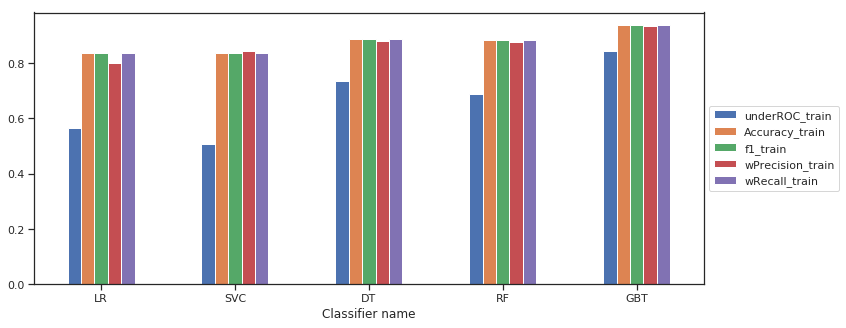

In [51]:
print(cvResults_data.toPandas().transpose())
cvResults_data_df = cvResults_data.toPandas().set_index('Classifier name')

ax = cvResults_data_df.plot.bar(rot=0, figsize=(12,5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

                      0      1      2      3      4
Classifier name      LR    SVC     DT     RF    GBT
underROC_train    0.744  0.763  0.847  0.844  0.971
Accuracy_train    0.744  0.763  0.847  0.844  0.971
f1_train          0.744  0.763  0.847  0.844  0.971
wPrecision_train  0.744  0.763  0.847  0.847  0.971
wRecall_train     0.744  0.763  0.847  0.844  0.971


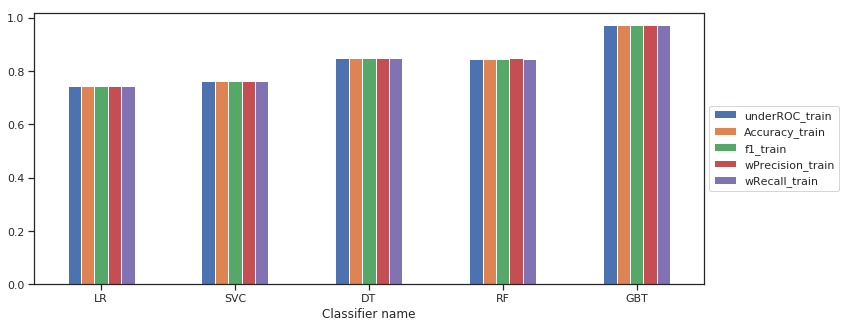

In [52]:
print(cvResults_stratified_data.toPandas().transpose())
cvResults_stratified_data_df = cvResults_stratified_data.toPandas().set_index('Classifier name')

ax = cvResults_stratified_data_df.plot.bar(rot=0, figsize=(12,5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))